# Paterson's Worms
This is a python implementation of Paterson's worms by Samuel Cabrera and Alana Huitric.

In [ ]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import cm
from IPython.display import clear_output
from os.path import basename, exists
from collections import Counter
from empiricaldist import Pmf
from utils import decorate, savefig
from collections import Counter
from empiricaldist import Pmf
from utils import decorate, savefig


ModuleNotFoundError: ignored

In [ ]:
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell1D.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

The following class implements Paterson's Worms.

In [ ]:
class Worm():
    """Implementation of Paterson's Worms."""
    def __init__(self, r, c, food_layer, worm_layer, worm_instructions):
        """Initializes the attributes.

        r: row
        c: column
        food_layer: complete NetworkX triangular grid graph and positions
        worm_layer: edgeless graph that uses node positions of food_layer
        worm_instructions: tuple ruleset for worms
        
        """
        self.row = r 
        self.col = c 
        self.path = {} #traveled nodes
        self.food_layer = food_layer
        self.worm_layer = worm_layer
        self.positions = nx.get_node_attributes(food_layer, 'pos')
        self.dir = 2 # initializes starting direction to the right
        self.worm_inst = worm_instructions
        self.rules = self.make_worm_ruleset(self.worm_inst)
        self.steps = 0 # length of worm - 1
        self.visited_nodes = set()
        self.worm_colors = {}

    def move(self): 
      """Moves the head of the worm to another using the ruleset"""
      pos = (self.row,self.col)

      if self.steps == 0:
        new_pos = (pos[0]+1,pos[1])
        self.visited_nodes.add(new_pos)
        self.visited_nodes.add(pos)
        self.worm_layer.add_edge(pos, new_pos, weight = self.steps)
        self.steps += 1
        self.row = new_pos[0]
        self.col = new_pos[1]
        return 

      targets = self.worm_layer.neighbors(pos)
      dir_list = self.map_direction(targets,pos)
      instruction = self.encode_dir((dir_list[0],tuple(dir_list[1])))
      nex_pos = self.rules[instruction]
      if nex_pos == None:
        return None
      adjusted_pos = self.adjust_pos(nex_pos,dir_list)

      new_pos = self.next_node(pos,adjusted_pos)
      self.visited_nodes.add(new_pos)
      self.worm_layer.add_edge(pos, new_pos, weight = self.steps)
      self.steps += 1
      self.row = new_pos[0]
      self.col = new_pos[1]
      self.dir = adjusted_pos
      return

    def run_to_end(self):
      """Runs worm until it dies or reaches 50000 steps"""
      prev = -1
      while prev < self.steps:
        if self.steps > 2000:
          return
        self.move()
        prev +=1 

    def reflect_dir(self, dir):
      """Reflects inputted direction 180 degrees

      dir: incoming direction of worm
      """
      conv_dict = {0:3, 5:2, 2:5, 1:4,3:0, 4:1 }
      return conv_dict[dir]

    def adjust_pos(self, nex_pos, dir_list):
      """Adjusts the position to prevent overflow

      nex_pos: the potential next position of the worm
      dir_list: list of directions the worm has taken
      """
      two_map = {0:3, 5:2, 2:5, 3:0, 4:1, 1:4}
      overflow_map = {-3:3, -4:2, -5:1, -2:4, -1:5, 7:1, 6:0, 8:2, 9:3, 10:4, 11:5}
      error = 5 - dir_list[0]
      nex_pos = two_map[nex_pos] - error
      if nex_pos in overflow_map.keys():
        return overflow_map[nex_pos]
      return nex_pos

    def next_node(self, pos, adjust_pos):
      """Picks the next node for the worm to travel to.

      pos: current position of the worm
      adjust_pos: adjusted position of the next node
      """
      if pos[1] % 2 == 0:
        if adjust_pos == 0:
          return (pos[0]-1,pos[1]+1)
        if adjust_pos == 1:
          return (pos[0],pos[1]+1)
        if adjust_pos == 2:
          return (pos[0]+1,pos[1])
        if adjust_pos == 3:
          return (pos[0],pos[1]-1)
        if adjust_pos == 4:
          return (pos[0]-1,pos[1]-1)
        if adjust_pos == 5:
          return (pos[0]-1,pos[1])
      else:
        if adjust_pos == 0:
          return (pos[0],pos[1]+1)
        if adjust_pos == 1:
          return (pos[0]+1,pos[1]+1)
        if adjust_pos == 2:
          return (pos[0]+1,pos[1])
        if adjust_pos == 3:
          return (pos[0]+1,pos[1]-1)
        if adjust_pos == 4:
          return (pos[0],pos[1]-1)
        if adjust_pos == 5:
          return (pos[0]-1,pos[1])

    def map_direction(self, targets, pos):
      """Maps directions of neighboring nodes relative to the current node.
      targets: neighboring nodes 
      pos: current position"""
      dir_list = (self.dir,[])
      if (pos[1] % 2) == 0:
        dir_map = {(1,0): 2,(-1,0):5,(0,1):1,(-1,1):0,(0,-1):3,(-1,-1):4}
      else:
        dir_map = {(1,0): 2,(-1,0):5,(1,1):1,(0,1):0,(1,-1):3,(0,-1):4}

      for t in targets:
        m_diff =  t[0] - pos[0]
        n_diff =  t[1] - pos[1] 
        dir_list[1].append(dir_map[(m_diff,n_diff)])
        #tp = self.positions[t]

      if self.reflect_dir(self.dir) in dir_list[1]:
        dir_list[1].remove(self.reflect_dir(self.dir))
        dir_list = (dir_list[0], tuple((dir_list[1])))
        return dir_list

    def encode_dir(self, dir_list):
      """Encodes direction of a worm based on the neighboring nodes
      dir_list: list of neighboring node directions
      """
      two_map = {0:3, 5:2, 2:5, 3:0, 4:1, 1:4}
      overflow_map = {-3:3, -4:2, -5:1, -2:4, -1:5, 7:1, 6:0, 8:2, 9:3, 10:4, 11:5}
      if dir_list[0] != 5:
        dirs = []
        error = 5 - dir_list[0]
        for i in dir_list[1]:
          dirs.append(i+error)
        for i,val in enumerate(dirs):
          if val in overflow_map.keys():
            dirs[i] = overflow_map[val]
        for i,val in enumerate(dirs):
          dirs[i] = two_map[val]
        return (5, tuple(sorted(dirs)))
      else:
        new_list = (2, list(dir_list[1]))
        for i in range(len(new_list[1])):
          new_list[1][i] = two_map[new_list[1][i]]
      return(5, tuple(sorted(new_list[1])))

    def make_worm_ruleset(self,worm_instructions):
      """ Makes worm ruleset based on instructions
      
      worm_instructions: tuple of rules for the worm
      """
      ruleset = {}
      field_0 = {0:
                {(5,tuple(sorted([3,4,2]))):0,
                  (5,tuple(sorted([3,1,4]))):0,
                  (5,tuple(sorted([1,4,2]))):0,
                  (5,tuple(sorted([3,1,2]))):0,
                  (5,tuple(sorted([3,4,0]))):1,
                  (5,tuple(sorted([4,2,0]))):1,
                  (5,tuple(sorted([0,3,2]))):1,
                  (5,tuple(sorted([1,0,4]))):2,
                  (5,tuple(sorted([0,3,1]))):2,
                  (5,tuple(sorted([2,1,0]))):3},
                1:
                {(5,tuple(sorted([3,4,2]))):1,
                  (5,tuple(sorted([3,1,4]))):2,
                  (5,tuple(sorted([1,4,2]))):3,
                  (5,tuple(sorted([3,1,2]))):4,
                  (5,tuple(sorted([3,4,0]))):2,
                  (5,tuple(sorted([4,2,0]))):3,
                  (5,tuple(sorted([0,3,2]))):4,
                  (5,tuple(sorted([1,0,4]))):3,
                  (5,tuple(sorted([0,3,1]))):4,
                  (5,tuple(sorted([2,1,0]))):4}}
      field_1 = {0:
                {(5,(4,)):0,
                  (5,(3,)):0,
                  (5,(2,)):0,
                  (5,(1,)):0,
                  (5,(0,)):1},
                1:
                {(5,(4,)):1,
                  (5,(3,)):1,
                  (5,(2,)):1,
                  (5,(1,)):2,
                  (5,(0,)):2},
                2:
                {(5,(4,)):2,
                  (5,(3,)):2,
                  (5,(2,)):3,
                  (5,(1,)):3,
                  (5,(0,)):3},
                3:
                {(5,(4,)):3,
                  (5,(3,)):4,
                  (5,(2,)):4,
                  (5,(1,)):4,
                  (5,(0,)):4}}
      field_2 = {0:
                {(5,tuple(sorted([3,4]))):0,
                  (5,tuple(sorted([4,2]))):0},
                1:
                {(5,tuple(sorted([3,4]))):1,
                  (5,tuple(sorted([4,2]))):1},
                2:
                {(5,tuple(sorted([3,4]))):2,
                  (5,tuple(sorted([4,2]))):3}}
      field_3 = {0:
                {(5,tuple(sorted([3,2]))):0,
                  (5,tuple(sorted([3,1]))):2},
                1:
                {(5,tuple(sorted([3,2]))):1,
                  (5,tuple(sorted([3,1]))):0},
                2:
                {(5,tuple(sorted([3,2]))):4,
                  (5,tuple(sorted([3,1]))):4}}
      field_4 = {0:
                {(5,tuple(sorted([2,1]))):0,
                  (5,tuple(sorted([4,0]))):2},
                1:
                {(5,tuple(sorted([2,1]))):3,
                  (5,tuple(sorted([4,0]))):1},
                2:
                {(5,tuple(sorted([2,1]))):4,
                  (5,tuple(sorted([4,0]))):3}}
      field_5 = {0:
                {(5,tuple(sorted([0,1]))):2,
                  (5,tuple(sorted([2,0]))):4},
                1:
                {(5,tuple(sorted([1,0]))):3,
                  (5,tuple(sorted([2,0]))):1},
                2:
                {(5,tuple(sorted([1,0]))):4,
                  (5,tuple(sorted([2,0]))):3}}
      field_6 = {0:
                {(5,()):3},
                1:
                {(5,()):4}}
      all_worms = {(5,tuple(sorted([2,1,4,3]))):0,
                  (5,tuple(sorted([0,2,3,4]))):1,
                  (5,tuple(sorted([0,1,3,4]))):2,
                  (5,tuple(sorted([1,0,4,2]))):3,
                  (5,tuple(sorted([0,3,1,2]))):4,
                  (5,tuple(sorted([1,0,3,4,2]))):None}
      ruleset.update(all_worms)
      ruleset.update(field_0[worm_instructions[0]])
      ruleset.update(field_1[worm_instructions[1]])
      ruleset.update(field_2[worm_instructions[2]])
      ruleset.update(field_3[worm_instructions[3]])
      ruleset.update(field_4[worm_instructions[4]])
      ruleset.update(field_5[worm_instructions[5]])
      ruleset.update(field_6[worm_instructions[6]])
      return ruleset

    def draw_worm_static(self):
      """ Draws a plain black and white worm at whatever state it is currently in.
      """
      nx.draw(self.worm_layer, node_size = 1,pos = self.positions)

    def num_nodes(self):
      """ Returns the number of visited nodes.
      """
      return len(self.visited_nodes)

    def draw_worm(self):
      """ Draws a worm in color."""
      dict_edges = dict(self.worm_layer.edges)
      dict_keys = list(dict_edges.keys())
      dict_values = list(dict_edges.values())
      c = {}
      for i in range(len(dict_keys)-1):
          c[dict_keys[i]] = list(dict_values[i].values())[0]
      sort_edges = sorted(c, key = c.get)
      norm_e = mpl.colors.Normalize(vmin=0, vmax=len(sort_edges), clip=True)
      mapper_e = mpl.cm.ScalarMappable(norm=norm_e, cmap=plt.get_cmap('inferno'))
      d = dict(self.worm_layer.degree)
      low, *_, high = sorted(d.values())
      norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
      mapper = mpl.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap('Oranges'))
      nx.draw(self.worm_layer,nodelist=d, node_size = 1,node_color=[mapper.to_rgba(j) 
                    for j in d.values()], pos = self.positions, edge_color=[mapper_e.to_rgba(k) 
                    for k in c.values()])
      return

    def animate(self, frames, interval=None):
        """Animate the worm.

        frames: number of frames to draw
        interval: time between frames in seconds
        """
        self.colors = [f/frames for f in range(frames)]
        plt.figure()
        try:
            for i in range(frames-1):
                self.draw_worm()
                plt.show()
                if interval:
                    plt.sleep(interval)
                self.move()
                clear_output(wait=True)
            self.draw_worm()
            plt.show()
        except KeyboardInterrupt:
            pass


In [ ]:

def run_all_worms():
  """Run every possible encoding of worm, for 2000 steps on an 1100 x 1100 grid
      and dumps the correspoding worm encoding number, length, and unique node count
      on to a .txt file
        """
  text_file = open("sample.txt", "w")

  for i in range(2):
    for j in range(4):
      for k in range(3):
        for l in range(3):
          for g in range(3):
            for h in range(3):
              for b in range(2):
                Ground_Layer = nx.triangular_lattice_graph(1100,1100, with_positions=True)
                pos = nx.get_node_attributes(Ground_Layer, 'pos')
                Worm_Layer = nx.Graph()
                Worm_Layer.add_nodes_from(Ground_Layer.nodes())
                worm = Worm(450,450, Ground_Layer, Worm_Layer, (i,j,k,l,g,h,b))
                worm.run_to_end()
                text = str((i,j,k,l,g,h,b))+ " ,"  + str(worm.steps+1)+ " ,"  + str(worm.num_nodes()) + '\n'
                text_file.write(text)
  text_file.close()
  return 

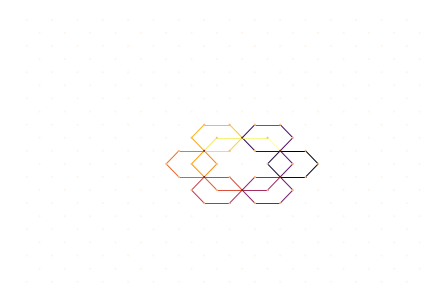

In [ ]:
Ground_Layer = nx.triangular_lattice_graph(20,30, with_positions=True)
pos = nx.get_node_attributes(Ground_Layer, 'pos')
Worm_Layer = nx.Graph()
Worm_Layer.add_nodes_from(Ground_Layer.nodes())
flower = Worm(10,10, Ground_Layer, Worm_Layer, (0,0,2,1,1,2,0))
flower.run_to_end()
flower.draw_worm()

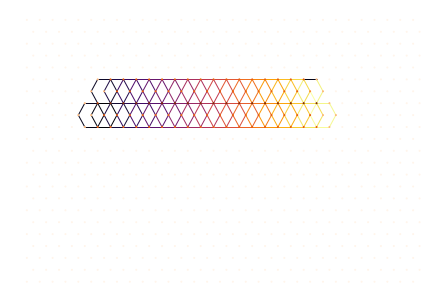

In [ ]:
Ground_Layer = nx.triangular_lattice_graph(22,60, with_positions=True)
pos = nx.get_node_attributes(Ground_Layer, 'pos')
Worm_Layer = nx.Graph()
Worm_Layer.add_nodes_from(Ground_Layer.nodes())
ribbon = Worm(5,15, Ground_Layer, Worm_Layer, (0,3, 2, 1, 2, 2, 0))
for i in range(200):
  ribbon.move()
ribbon.draw_worm()

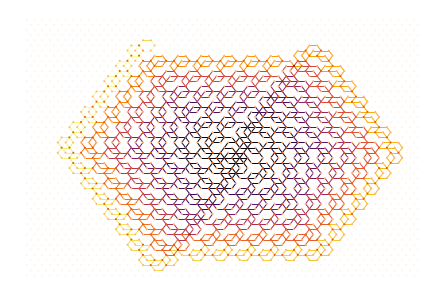

In [ ]:
Ground_Layer = nx.triangular_lattice_graph(50,100, with_positions=True)
pos = nx.get_node_attributes(Ground_Layer, 'pos')
Worm_Layer = nx.Graph()
Worm_Layer.add_nodes_from(Ground_Layer.nodes())
splatter = Worm(25,25, Ground_Layer, Worm_Layer, (0, 2, 0, 2, 0, 1, 0))
for i in range(2000):
  splatter.move()
splatter.draw_worm()

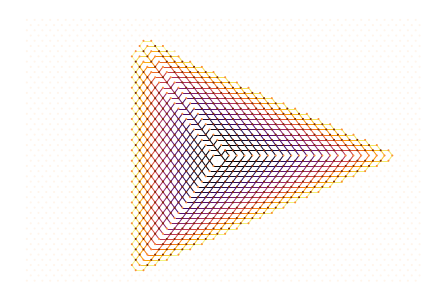

In [ ]:
Ground_Layer = nx.triangular_lattice_graph(50,100, with_positions=True)
pos = nx.get_node_attributes(Ground_Layer, 'pos')
Worm_Layer = nx.Graph()
Worm_Layer.add_nodes_from(Ground_Layer.nodes())
sword = Worm(25,25, Ground_Layer, Worm_Layer, (1, 3, 1, 1, 0, 2, 0))
for i in range(1500):
  sword.move()
sword.draw_worm()

NetworkXError: ignored

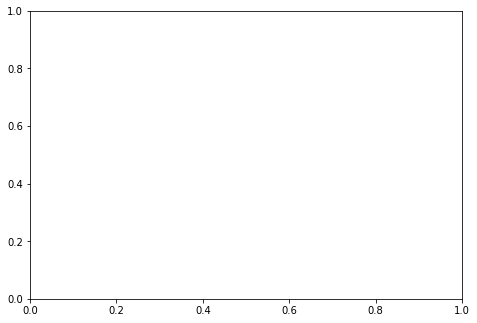

In [ ]:
Ground_Layer = nx.triangular_lattice_graph(50,100, with_positions=True)
pos = nx.get_node_attributes(Ground_Layer, 'pos')
Worm_Layer = nx.Graph()
Worm_Layer.add_nodes_from(Ground_Layer.nodes())
triangle = Worm(25,25, Ground_Layer, Worm_Layer, (1, 3, 1, 1, 0, 2, 0))
triangle.animate(2500)
#for i in range(2500):
#  triangle.move()
#triangle.draw_worm()

In [ ]:
Ground_Layer = nx.triangular_lattice_graph(50,100, with_positions=True)
pos = nx.get_node_attributes(Ground_Layer, 'pos')
Worm_Layer = nx.Graph()
Worm_Layer.add_nodes_from(Ground_Layer.nodes())
triangle = Worm(25,25, Ground_Layer, Worm_Layer, (0, 2, 0, 1, 0, 2, 0))
triangle.animate(500)

### Plotting Code

In [ ]:
import pandas as pd
"""Read in the data, organize it into a pd df and 
    prepare it for plotting. 
        """
data = pd.read_csv('sample2.txt', header = None)
data.columns = ["Field 0", "Field 1", "Field 2", "Field 3", "Field 4", "Field 5", "Field 6", "Worm Length", "Nodes Visited"]
lenghts = data["Worm Length"]
nodes = data["Nodes Visited"]
test = data["Field 0"].tolist()
test2 = data["Field 1"].tolist()
test3 = data["Field 2"].tolist()
test4 = data["Field 3"].tolist()
test5 = data["Field 4"].tolist()
test6 = data["Field 5"].tolist()
test7 = data["Field 6"].tolist()
new_list = []
for i in range(len(test)):
    new_list.append(test[i]+str(test2[i])+str(test3[i])+str(test4[i])+str(test5[i])+str(test6[i])+test7[i].strip())
info = data.drop(columns=["Field 0", "Field 1", "Field 2", "Field 3", "Field 4", "Field 5", "Field 6"])
info.insert(0, 'Worm Number', new_list)
info = info.sort_values("Worm Length")


In [ ]:
"""Plots the Worm lenghts in increasing order
        """

options = dict(ls='', marker='.')


ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.xaxis.set_ticklabels([])

plt.plot(info["Worm Number"], info["Worm Length"], **options)
plt.xlabel("Worm Encoding Number")
plt.ylabel("Worm Length (Capped at 2000)")
plt.title("Worm Length in ascending order")
savefig('Worm_length')

In [ ]:
"""Makes a pmf of the worm lenghts and plots it in regular scale
        """
count = Counter(info["Worm Length"])
things = [keys for keys in count.keys()]
things_1 = [vals for vals in count.values()]
pmf_wl = Pmf.from_seq(info["Worm Length"])
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')
pmf_wl.plot(**options)
plt.xlabel("Number of Worms with Length x")
plt.ylabel("PMF")
plt.title("Worm Length PMF Log-Log")
decorate(xscale='log', yscale='log',
         xlabel='Number of Worms with Length', ylabel='PMF')
savefig('PMF_loglog')

In [ ]:
"""Makes a pmf of the worm lenghts and plots it in log log scale
        """
count = Counter(info["Worm Length"])
things = [keys for keys in count.keys()]
things_1 = [vals for vals in count.values()]
pmf_wl = Pmf.from_seq(info["Worm Length"])
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')
pmf_wl.plot(**options)
plt.xlabel("Number of Worms with Length x")
plt.ylabel("PMF")
plt.title("Worm Length PMF")
savefig('PMF')